In [68]:
# Tilføj Jupiter som kæmpe bold i baggrunden
# Kør animationen længere på sidste produkt
# Lav 5 forskellige plots, 1 som den er, 1 for hvert plot men seperat, og en uden akser og ektra plots
# 

#imports
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import time
from IPython import display
import sys

In [69]:
#constants
# PHYSICAL PARAMETERS

Mj      = 8.93e22 #  kg      Io mass
Rj      = 1.82e6 #  m      Io radius
G       = 6.67e-11 #  Gravitational constant in SI units

# SIMULATION PARAMETERS
Ninit   = 1000 # Number of particles (if new object is created)
m       = Mj/Ninit # SPH particle mass 
dt      = 200 # Time step size
ball_size = Rj / (np.cbrt(Ninit) * np.sqrt(2))
print(ball_size)


128693.43417595164


In [70]:
def init_IO(n):
    
    init_state = [np.zeros([6])]
    
    while len(init_state) < n:
        if len(init_state) % 100 == 0:
            print(len(init_state))
            
        tmp_state = np.zeros([6])
        tmp_state[:3] = (np.random.rand(3) - 0.5) * Rj * 2
        
        vec = (tmp_state - init_state)
        vec = vec[:,0:3]
        distance = np.sqrt(vec[:,0] ** 2 + vec[:,1] ** 2 + vec[:,2] ** 2)  
        
        if distance[0] > Rj * 1.05:
            continue
        
        if any(np.where((distance < 2 * ball_size))[0]):
            continue
            
        init_state.append(tmp_state)
        
    
    return np.array(init_state)

def init_comet(state, offset=0, moon_ratio=0.1):
    
    state = list(state)
    state.append([7e7, offset, 0, -1e6, 0, 0])

    while len(state) < int(Ninit + Ninit * moon_ratio):
        if len(state) % 100 == 0:
            print(len(state))

        tmp_state = [7e7, offset, 0, -1e6, 0, 0]
        tmp_state[:3] += (np.random.randn(3) - 0.5) * Rj #* 6 * moon_ratio
        
        vec = (tmp_state - np.array(state)[Ninit:])
        vec = vec[:,0:3]
        distance = np.sqrt(vec[:,0] ** 2 + vec[:,1] ** 2 + vec[:,2] ** 2)  
        
        if distance[0] > Rj * moon_ratio * 6:
            #print('too far away')
            continue
        
        if any(np.where((distance < 2 * ball_size))[0]):
            #print('too close to other ball')
            continue
            
        state.append(tmp_state)
        
    return np.array(state)



def new_state(state, Fi, distances):
    
    a = Fi / m
    
    if any(np.where((distances < 2 * ball_size) & (distances > 0))[0]):

        updates = np.where((distances < 2 * ball_size) & (distances > 0))
        to_be_updated = updates[0]
        updated_with = updates[1]
        state_updates = state[updated_with]        

        for i in range(0,len(to_be_updated)):
            #state[to_be_updated[i]][3:] = state_updates[i] * 0.999
            if to_be_updated[i] >= Ninit:
                state[to_be_updated[i]], s = collision(state[to_be_updated[i]], state_updates[i], 1)
            else: 
                state[to_be_updated[i]], s = collision(state[to_be_updated[i]], state_updates[i], 0.9)
            state[to_be_updated[i]][3:] -= a[to_be_updated[i]] * dt
    
    
    state[:,3:] += a * dt
    state[:,0:3] += state[:,3:]
    
    return state

    
    
def gravity_n_body(state):
    
    Fi = []
    distances = []

    for i in range(0, len(state)):
        
        vec = (state[i] - state)#np.delete(state, i, axis=0))
        vec = vec[:,0:3]
        distance = np.sqrt(vec[:,0] ** 2 + vec[:,1] ** 2 + vec[:,2] ** 2)  
        distances.append(distance)
        #print(vec)
        #print((vec.transpose()/distance**3).transpose())
        Fi.append(np.sum(- G * m ** 2 * np.nan_to_num(vec.transpose()/distance**3).transpose(), axis = 0))
        Fi_max = - G * m ** 2 * 10 * ball_size / ball_size**3
        
        if len(np.where((abs(np.array(Fi)[-1]) > abs(Fi_max)))[0]) > 0:
            
            for i in np.where((abs(np.array(Fi)[-1]) > abs(Fi_max)))[0]:
                if Fi[-1][i] > 0:
                    Fi[-1][i] = Fi_max
                else:
                    Fi[-1][i] = -Fi_max
            #print(abs(np.array(Fi)[-1]))
            #print(abs(Fi_max))
            #print(np.where((abs(np.array(Fi)[-1]) > abs(Fi_max)))[0])
            
            #break
        
    return np.array(Fi), np.array(distances)


def collision(state1, state2, inelasticity=1):
    """
    tmp_state = np.array([state1[3:], state2[3:]])

    state1[3:] = tmp_state[1] * inelasticity
    state2[3:] = tmp_state[0] * inelasticity

    """
    state_diff = state1[0:3] - state2[0:3]
    #print(state_diff)
    n = np.nan_to_num(state_diff / len_vec(state_diff))
    #print(n, len_vec(n))
    
    v_rel = state1[3:] - state2[3:]
    #print(v_rel)
    v_norm = np.dot(v_rel, n) * n
    #print(v_norm)
    
    state1[3:] = (state1[3:] - v_norm) * inelasticity
    state2[3:] = (state2[3:] + v_norm) * inelasticity
    #state1[:3] = state2[:3] + n * ball_size
    
    return state1, state2


    
def len_vec(vec):
    
    return np.sqrt(np.sum([i ** 2 for i in vec]))
    


In [71]:
# generate IO and comet
offset = 1.5e6
moon_ratio = 0.1

start_state = init_IO(n=Ninit)
print('done generating IO')

start_state = init_comet(start_state, offset=offset, moon_ratio=moon_ratio)
print('done generating comet')

100
100
200
200
300
300
300
400
400
400
400
500
500
500
600
600
600
600
600
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
900
900
900
900
900
900
done generating IO
done generating comet


In [72]:
# create plot states

N = 2000 # animation frames
state = start_state
states = []
for i in range(0,N):
    
    if i % 10 == 0:
        print('calculating state', i)
    #print(state)
    Fi, distances = gravity_n_body(state)

    state = new_state(state, Fi, distances)
    #print(state, '\n')
    states.append(np.array(state))
    #print(states)
    #print('--------------')
    


calculating state 0


C:\Users\mikkel\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide


calculating state 10
calculating state 20
calculating state 30
calculating state 40
calculating state 50
calculating state 60
calculating state 70
calculating state 80
calculating state 90
calculating state 100
calculating state 110
calculating state 120
calculating state 130
calculating state 140
calculating state 150
calculating state 160
calculating state 170
calculating state 180
calculating state 190
calculating state 200
calculating state 210
calculating state 220
calculating state 230
calculating state 240
calculating state 250
calculating state 260
calculating state 270
calculating state 280
calculating state 290
calculating state 300
calculating state 310
calculating state 320
calculating state 330
calculating state 340
calculating state 350
calculating state 360
calculating state 370
calculating state 380
calculating state 390
calculating state 400
calculating state 410
calculating state 420
calculating state 430
calculating state 440
calculating state 450
calculating state 4

In [73]:
#np.save('n=1000IO_crash', states)

In [74]:
#generate distances

distances = []

for i in range(0,len(states[0])):
    vec = (states[0][i] - states[0])#np.delete(state, i, axis=0))
    vec = vec[:,0:3]
    distance = np.sqrt(vec[:,0] ** 2 + vec[:,1] ** 2 + vec[:,2] ** 2)  
    distances.append(distance[0])
    

colors = distances
colors[Ninit:] = np.zeros([len(distances[Ninit:])])


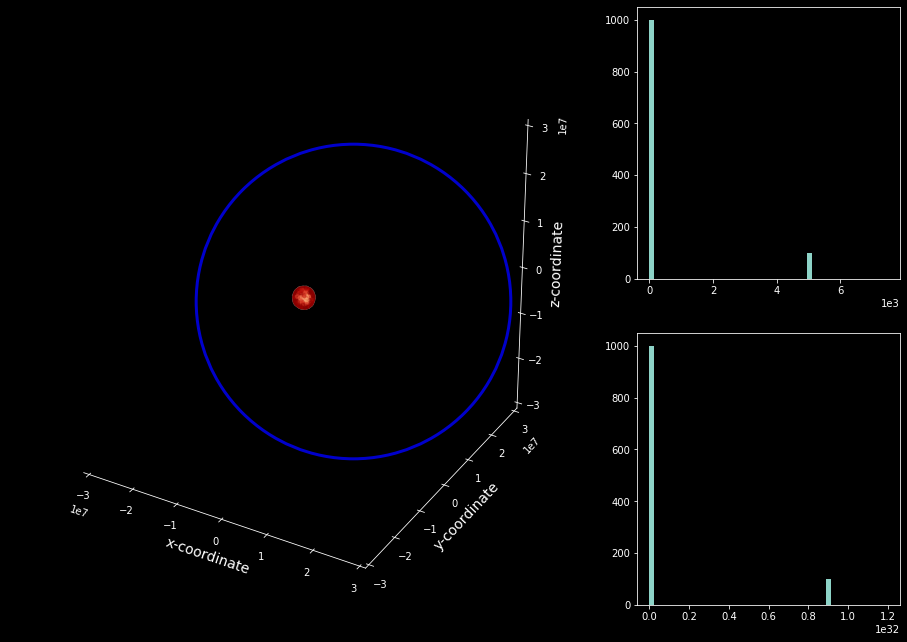

In [75]:
# for plot testing

import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path):
    return OffsetImage(plt.imread(path))


plt.style.use('dark_background')
# test init plot
zoom = 1e7
fig = plt.figure(figsize=(16,11))
# set up subplot grid
gridspec.GridSpec(3,3)
plt.set_cmap('OrRd')

# large subplot
ax = plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2, projection='3d')
scatters = ax.scatter(states[0][:,0], states[0][:,1], states[0][:,2], s=ball_size/10000)#, c=distances)
at = ax.scatter(-1e8, 2e8, -1.3e8, s=ball_size/1.3, alpha=0.8, facecolors='k', edgecolors='b', linewidths=3)#, c=distances)
#ab = AnnotationBbox(getImage(r'C:\Users\mikkel\Desktop\planet_sim\jupiter1.jpg'), (0, 0), frameon=False)
#at = ax.add_artist(ab)
at.zorder = 0

# small subplot 1
ax2 = plt.subplot2grid((2,3), (0,2))
vel_hist = ax2.hist(np.sqrt(states[0][:,3] ** 2 + states[0][:,4] ** 2 + states[0][:,5] ** 2) / dt , bins=np.linspace(0,1.5e6,51) / dt)
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# small subplot 2
plt.subplot2grid((2,3), (1,2))
plt.hist(m * (states[0][:,3] ** 2 + states[0][:,4] ** 2 + states[0][:,5] ** 2), bins=np.linspace(0,1.2e32,51))

# small subplot 3
#plt.subplot2grid((3,3), (2,2))
#plt.hist(np.sqrt(states[0][:,3] ** 2 + states[0][:,4] ** 2 + states[0][:,5] ** 2), bins=np.linspace(0,1.2e32,51))

#
#ax.view_init(elev=90, azim=0) # view x-y
#ax.view_init(elev=0, azim=0) # view y-z
#ax.view_init(elev=0, azim=90) # view x-z

scatters = ax.scatter(states[0][:,0], states[0][:,1], states[0][:,2], s=ball_size/10000, c=distances)

    
ax.view_init(elev=30, azim=-60)
#ax.plot_surface(img_x * 5, img_y * 5, img_z, rstride=10, cstride=10, facecolors=img)
#scatters = ax.scatter(states[0][:,0], states[0][:,1], states[0][:,2], s=ball_size/10000, c=distances)



# Setting the axes properties
ax.set_xlim3d(-3*zoom, 3*zoom)
ax.set_ylim3d(-3*zoom, 3*zoom)
ax.set_zlim3d(-3*zoom, 3*zoom)

ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

Done creating animation


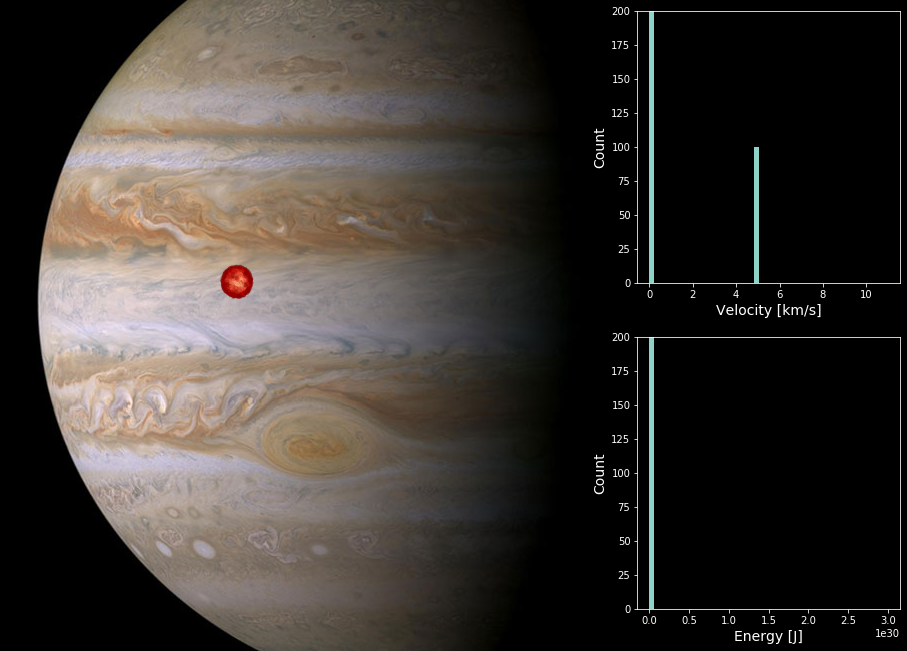

Wall time: 14min 23s


In [76]:
%%time
# Generate the animation

plt.style.use('dark_background')
from matplotlib import pyplot as plt
import numpy as np
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cbook import get_sample_data
from matplotlib._png import read_png
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path):
    return OffsetImage(plt.imread(path))

# test init plot
fig = plt.figure(figsize=(16,11))
# set up subplot grid
gridspec.GridSpec(3,3)

# large subplot
ax1 = plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2, projection='3d')
at = ax1.scatter(-1e8, 2e8, -1.2e8, s=ball_size/1.3, alpha=0.8, facecolors='k', edgecolors='b', linewidths=3)
#ab = AnnotationBbox(getImage(r'C:\Users\mikkel\Desktop\planet_sim\jupiter1.jpg'), (0, 0), frameon=False)
#at = ax1.add_artist(ab)
at.zorder = 0
scatters = ax1.scatter(states[0][:,0], states[0][:,1], states[0][:,2], s=ball_size/10000, c=distances, cmap='OrRd')

# small subplot 1
ax2 = plt.subplot2grid((2,3), (0,2))
vel_hist = ax2.hist(np.sqrt(states[0][:,3] ** 2 + states[0][:,4] ** 2 + states[0][:,5] ** 2) / dt / 1000., bins=np.linspace(0,20,51))
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


# small subplot 2
ax3 = plt.subplot2grid((2,3), (1,2))
e_hist = ax3.hist(m * (states[0][:,3] ** 2 + states[0][:,4] ** 2 + states[0][:,5] ** 2), bins=np.linspace(0,1.5e31,51))


def update(states):
    
    # update 3d plot
    scatters._offsets3d = (states[:,0], states[:,1], states[:,2])
    
    # update histograms
    ax2.cla()
    ax2.set_ylim(0, Ninit/5)
    vel_hist = ax2.hist(np.sqrt(states[:,3] ** 2 + states[:,4] ** 2 + states[:,5] ** 2) / dt / 1000., bins=np.linspace(0,11,51))
    ax2.set_xlabel("Velocity [km/s]",fontsize=14)
    ax2.set_ylabel("Count",fontsize=14)
    #ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    ax3.cla()
    ax3.set_ylim(0, Ninit/5)
    e_hist = ax3.hist(m * (states[:,3] ** 2 + states[:,4] ** 2 + states[:,5] ** 2), bins=np.linspace(0,3e30,51))
    ax3.set_xlabel("Energy [J]",fontsize=14)
    ax3.set_ylabel("Count",fontsize=14)

    return scatters


#fn = get_sample_data(r'C:\Users\mikkel\Desktop\planet_sim\jupiterlarge.png', asfileobj=False)
#img = read_png(fn)

zoom = 1e7


ax1.view_init(elev=30, azim=-60)


# Setting the axes properties
ax1.set_xlim3d(-1*zoom, 3*zoom)
ax1.set_ylim3d(-2*zoom, 2*zoom)
ax1.set_zlim3d(-2*zoom, 2*zoom)

ax1.set_xlabel("X [m]",fontsize=14)
ax1.set_ylabel("Y [m]",fontsize=14)
ax1.set_zlabel("Z [m]",fontsize=14)

# make the panes transparent
ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax1.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax1.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax1.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax2.set_ylim(0,Ninit/5)
ax2.set_xlabel("Velocity [m/s]",fontsize=14)
ax2.set_ylabel("Count",fontsize=14)
#ax2.ticklabel_format(style='sci')

ax3.set_ylim(0,Ninit/5)
ax3.set_xlabel("Energy [J]",fontsize=14)
ax3.set_ylabel("Count",fontsize=14)

writer = animation.writers['ffmpeg'](fps=20)
ani = animation.FuncAnimation(fig, update, states, interval=50, blit=False)
save_name = 'IO_crash_%iparticles_%ioffset_%fcometRatio.gif' %(Ninit, offset, moon_ratio)
ani.save('matplot003.mp4', writer=writer)

print('Done creating animation')
plt.show()




In [66]:
np.random.rand(3) - 0.5

array([ 0.07991035, -0.07782901, -0.37622322])